In [1]:
from __future__ import absolute_import, division #, print_function
import tensorflow as tf
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
import os
import csv
from random import randint, random
import time
import math
from heapq import heappush, heappop

os.environ["CUDA_VISIBLE_DEVICES"]="0"
config = tf.ConfigProto()
config.gpu_options.allow_growth=True

In [2]:
# setup dimensions and training specs-
# x, u, z, data, mb, lr
img_res = 32
img_dim = img_res*img_res

x_dim = img_dim
y_dim = img_dim
u_dim = 2 # control effort
z_dim = 2
data_dim = 3*img_dim + u_dim # x_i, x_i+1, x_empty (to pass through obstacles), control input (x,y unit vector)

mb_size = 128
lr = 1e-4

In [3]:
################## Latent Sampling-based Motion Planning Network ##################
## inputs
tf.reset_default_graph() 

x = tf.placeholder(tf.float32, shape=[None, x_dim], name="x")
xp = tf.placeholder(tf.float32, shape=[None, x_dim], name="xp")
xempty = tf.placeholder(tf.float32, shape=[None, x_dim], name="xempty")
u = tf.placeholder(tf.float32, shape=[None, u_dim], name="u")

batch_size = tf.shape(u)[0]

# put x and xp together, x_i's next point is x_{i+batch_size}
x_full = tf.concat([x, xp], axis=0)
inputs_Q = tf.reshape(x_full, [-1, img_res, img_res, 1]) # setup for convolution

## architecture sizes
h_Q_dim = 256
h_P_dim = 512
h_env_dim = 512

tf.summary.scalar('lr', lr)
tf.summary.scalar('h_Q_dim', h_Q_dim)
tf.summary.scalar('h_P_dim', h_P_dim)

## Q, Encoder
conv_Q1_filters = 8
conv_Q1_filter_width = 4
pool_Q1_stride = 1

conv_Q1 = tf.layers.conv2d(
     inputs=inputs_Q,
     filters=conv_Q1_filters,
     kernel_size=[conv_Q1_filter_width, conv_Q1_filter_width],
     padding="same",
     activation=tf.nn.relu,
     name="conv_Q1")

conv_Q2_filters = 8
conv_Q2_filter_width = 4
pool_Q2_stride = 1

conv_Q2 = tf.layers.conv2d(
     inputs=conv_Q1,
     filters=conv_Q2_filters,
     kernel_size=[conv_Q2_filter_width, conv_Q2_filter_width],
     padding="same",
     activation=tf.nn.relu,
     name="conv_Q2")

conv_Q3_filters = 8
conv_Q3_filter_width = 4
pool_Q3_stride = 1

conv_Q3 = tf.layers.conv2d(
     inputs=conv_Q2,
     filters=conv_Q3_filters,
     kernel_size=[conv_Q3_filter_width, conv_Q3_filter_width],
     padding="same",
     activation=tf.nn.relu,
     name="conv_Q3")

spatial_softmax = tf.contrib.layers.spatial_softmax(conv_Q3)

dense_Q1 = tf.layers.dense(inputs=spatial_softmax, units=h_Q_dim, activation=tf.nn.relu, name="dense_Q1")
dropout_Q1 = tf.layers.dropout(inputs=dense_Q1, rate=0.5)
dense_Q2 = tf.layers.dense(inputs=dropout_Q1, units=h_Q_dim, activation=tf.nn.relu, name="dense_Q2")

z = tf.layers.dense(inputs=dense_Q2, units=z_dim, name="z")

## D, Dynamics Network, layer sizes inspired by https://arxiv.org/pdf/1710.05373.pdf
zc = z[:batch_size,:] # z_current, only first mb_size (the ones from x, not xp)
uc = u[:batch_size,:]
inputs_D = tf.concat([zc, uc], axis=1)
inputs_D = tf.identity(inputs_D, name="inputs_D")

dense_D1 = tf.layers.dense(inputs=inputs_D, units=128, activation=tf.nn.relu, name="dense_D1")
dropout_D1 = tf.layers.dropout(inputs=dense_D1, rate=0.5)
dense_D2 = tf.layers.dense(inputs=dropout_D1, units=128, activation=tf.nn.relu, name="dense_D2")
dropout_D2 = tf.layers.dropout(inputs=dense_D2, rate=0.5)
dense_D3 = tf.layers.dense(inputs=dropout_D2, units=128, activation=tf.nn.relu, name="dense_D3")

zp_predict = tf.layers.dense(inputs=dense_D3, units=z_dim, activation=tf.nn.relu, name="zp_predict")

inputs_P = tf.concat([zc, zp_predict], axis=0)
inputs_P = tf.identity(inputs_P, name="inputs_P")

dense_P1 = tf.layers.dense(inputs=inputs_P, units=h_P_dim, activation=tf.nn.relu, name="dense_P1")
dropout_P1 = tf.layers.dropout(inputs=dense_P1, rate=0.5)
dense_P2 = tf.layers.dense(inputs=dropout_P1, units=h_P_dim, activation=tf.nn.relu, name="dense_P2")
dropout_P2 = tf.layers.dropout(inputs=dense_P2, rate=0.5)
dense_P3 = tf.layers.dense(inputs=dropout_P2, units=h_P_dim, activation=tf.nn.relu, name="dense_P3")
dropout_P3 = tf.layers.dropout(inputs=dense_P3, rate=0.5)
dense_P4 = tf.layers.dense(inputs=dropout_P3, units=h_P_dim, activation=tf.nn.relu, name="dense_P4")

## Environment Network
conv_env1_filters = 4
conv_env1_filter_width = 4
pool_env1_stride = 1

xempty_full = tf.concat([xempty, xempty], axis=0)
inputs_env = tf.reshape(xempty_full, [-1, img_res, img_res, 1]) # setup for convolution
inputs_env = tf.identity(inputs_env, name="inputs_env")
conv_env1 = tf.layers.conv2d(
     inputs=inputs_env,
     filters=conv_env1_filters,
     kernel_size=[conv_env1_filter_width, conv_env1_filter_width],
     padding="same",
     activation=tf.nn.relu,
     name="conv_env1")
conv_env1_flat = tf.reshape(conv_env1, [-1, x_dim*conv_env1_filters], name="pool_env1_flat")
dense_env1 = tf.layers.dense(inputs=conv_env1_flat, units=h_env_dim, activation=tf.nn.relu, name="dense_env1")
dropout_env1 = tf.layers.dropout(inputs=dense_env1, rate=0.5)
dense_env2 = tf.layers.dense(inputs=dropout_env1, units=h_env_dim, activation=tf.nn.relu, name="dense_env2")
dropout_env2 = tf.layers.dropout(inputs=dense_env2, rate=0.5)
dense_env3 = tf.layers.dense(inputs=dropout_env2, units=h_env_dim, activation=tf.nn.relu, name="dense_env3")
dropout_env3 = tf.layers.dropout(inputs=dense_env3, rate=0.5)
dense_env4 = tf.layers.dense(inputs=dropout_env3, units=h_env_dim, activation=tf.nn.relu, name="dense_env4")

## y, output
inputs_y = tf.concat(values=[dense_P4, dense_env4], axis=1)
y = tf.layers.dense(inputs=inputs_y, units=y_dim, name="y") 

## local linearization for losses and nearest neighbor
zp_predict1 = zp_predict[:,0]
zp_predict2 = zp_predict[:,1]

grad_zp1_zc = tf.gradients(zp_predict1, zc, name="grad_zp1_zc") 
grad_zp2_zc = tf.gradients(zp_predict2, zc, name="grad_zp2_zc")
grad_zp1_uc = tf.gradients(zp_predict1, uc, name="grad_zp1_uc")
grad_zp2_uc = tf.gradients(zp_predict2, uc, name="grad_zp2_uc")

A = tf.stack([grad_zp1_zc[0], grad_zp2_zc[0]], axis=1, name="A")
B = tf.stack([grad_zp1_uc[0], grad_zp2_uc[0]], axis=1, name="B")
c = tf.expand_dims(zp_predict,-1) - tf.matmul(A,tf.expand_dims(zc,-1)) - tf.matmul(B,tf.expand_dims(uc,-1))
AT = tf.transpose(A, perm=[0, 2, 1])
BT = tf.transpose(B, perm=[0, 2, 1])

G = tf.matmul(A,tf.matmul(B,tf.matmul(BT,AT)))
G_inv = tf.matrix_inverse(G + 0.0001*tf.eye(tf.shape(G)[1], batch_shape=[batch_size]))
G_inv_stop = tf.stop_gradient(G_inv) # shouldn't be optimizing G_inv (tendancy to shink state space into the 0.0001*diag)

## loses
z_miss = tf.expand_dims(zp_predict,-1) - tf.expand_dims(z[batch_size:,:],-1)
z_missT = tf.transpose(z_miss, perm=[0, 2, 1])

predict_loss_G = tf.reduce_sum(tf.abs(tf.matmul(z_missT, tf.matmul(G_inv_stop, z_miss))))
tf.summary.scalar('predict_loss_G', predict_loss_G)

predict_loss_L2 = tf.losses.mean_squared_error(labels=z[batch_size:,:], predictions=zp_predict)
tf.summary.scalar('predict_loss_L2', predict_loss_L2)

L2_weight = tf.placeholder(tf.float32, shape=[1], name="L2_weight")
tf.summary.scalar('L2_weight', tf.reduce_mean(L2_weight))
predict_loss = tf.reduce_mean(predict_loss_L2*L2_weight) + tf.reduce_mean(predict_loss_G*(1-L2_weight))

recon_loss = tf.losses.mean_squared_error(labels=x_full, predictions=y)
tf.summary.scalar('recon_loss', recon_loss)

total_loss = tf.reduce_mean(recon_loss) + predict_loss
tf.summary.scalar('total_loss', total_loss)

train_step = tf.train.AdamOptimizer(lr).minimize(total_loss)

################## Collision checking network ##################
h_CC_dim = 128
conv_CC_filters = 10
conv_CC_filter_width = 6
pool_CC_stride = 1

z1_CC = tf.placeholder(tf.float32, shape=[None, z_dim], name="z1_CC")
z2_CC = tf.placeholder(tf.float32, shape=[None, z_dim], name="z2_CC")
x_CC = tf.placeholder(tf.float32, shape=[None, x_dim], name="x_CC") # image of x_init or x_empty
label_CC = tf.placeholder(tf.float32, shape=[None, 1], name="label_CC") # valid path or not (labels, 1 is valid, 0 is not)

# pass through conv net then combine with z's
inputs_conv_CC = tf.reshape(x_CC, [-1, img_res, img_res, 1])
conv_CC1 = tf.layers.conv2d(
     inputs=inputs_conv_CC,
     filters=conv_CC_filters,
     kernel_size=[conv_CC_filter_width, conv_CC_filter_width],
     padding="same",
     activation=tf.nn.relu,
     name="conv_CC1")

conv_CC2 = tf.layers.conv2d(
     inputs=conv_CC1,
     filters=conv_CC_filters,
     kernel_size=[conv_CC_filter_width, conv_CC_filter_width],
     padding="same",
     activation=tf.nn.relu,
     name="conv_CC2")

conv_CC3 = tf.layers.conv2d(
     inputs=conv_CC2,
     filters=conv_CC_filters,
     kernel_size=[conv_CC_filter_width, conv_CC_filter_width],
     padding="same",
     activation=tf.nn.relu,
     name="conv_CC3")

conv_CC_flat = tf.reshape(conv_CC3, [-1, img_res*img_res*conv_CC_filters], name="conv_CC_flat")
dense_CC_conv = tf.layers.dense(inputs=conv_CC_flat, units=4*h_CC_dim, activation=tf.nn.relu, name="dense_CC_conv")

zs_CC = tf.concat(axis=1, values=[z1_CC, z2_CC])
dense_CC_zs = tf.layers.dense(inputs=zs_CC, units=4*h_CC_dim, activation=tf.nn.relu, name="dense_CC_zs")

inputs_CC = tf.concat(axis=1, values=[dense_CC_zs, dense_CC_conv]) 
dense_CC1 = tf.layers.dense(inputs=inputs_CC, units=h_CC_dim, activation=tf.nn.relu, name="dense_CC1")
dropout_CC1 = tf.layers.dropout(inputs=dense_CC1, rate=0.5)
dense_CC2 = tf.layers.dense(inputs=dropout_CC1, units=h_CC_dim, activation=tf.nn.relu, name="dense_CC2")
dropout_CC2 = tf.layers.dropout(inputs=dense_CC2, rate=0.5)
dense_CC3 = tf.layers.dense(inputs=dropout_CC2, units=h_CC_dim, activation=tf.nn.relu, name="dense_CC3")
dropout_CC3 = tf.layers.dropout(inputs=dense_CC3, rate=0.5)
dense_CC4 = tf.layers.dense(inputs=dropout_CC3, units=h_CC_dim, activation=tf.nn.relu, name="dense_CC4")
dropout_CC4 = tf.layers.dropout(inputs=dense_CC4, rate=0.5)
dense_CC5 = tf.layers.dense(inputs=dropout_CC4, units=h_CC_dim, activation=tf.nn.relu, name="dense_CC5")

y_CC = tf.layers.dense(inputs=dense_CC5, units=1, name="y_CC")

CC_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=label_CC, logits=y_CC)
tf.summary.scalar('CC_loss', CC_loss)

train_step_CC = tf.train.AdamOptimizer(lr).minimize(CC_loss)

## Initialize
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())
it = 0
it_CC = 0

## write to tensorboard
writer = tf.summary.FileWriter('summary' + time.strftime("%Y_%m_%dat%H:%M:%S", time.localtime()), sess.graph)
merged = tf.summary.merge_all()

print('done')




Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Use keras.layers.dropout instead.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where






2025-07-11 10:39:59.865889: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2025-07-11 10:39:59.869091: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3072000000 Hz
2025-07-11 10:39:59.870293: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x2b0befa0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-07-11 10:39:59.870306: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version




done


In [4]:
#### Pretrained model (be sure to unzip model folder)
# The data is too large to store on github for training. 
# We plan as to soon have an FTP running with data

reader = tf.train.NewCheckpointReader("model/LSBMP_geometric.ckpt")
restore_dict = dict()
for v in tf.trainable_variables():
    tensor_name = v.name.split(':')[0]
    if reader.has_tensor(tensor_name):
        restore_dict[tensor_name] = v
        # print('has tensor ', tensor_name)

saver = tf.train.Saver(restore_dict)
saver.restore(sess, "model/LSBMP_geometric.ckpt")
print("Model restored (as best I could).")




INFO:tensorflow:Restoring parameters from model/LSBMP_geometric.ckpt
Model restored (as best I could).


# L2RRT

In [5]:
## import the data for samples (also similar to what training data looks like)

######### Original code containing bugs #########
# filename = 'data/geometric_data.csv' 
# f = open(filename, 'rb')
# reader = csv.reader(f, delimiter=',')
# count = 0
# data_list = []
# for row in reader:
#     data_list.append(map(float,row[0:data_dim]))

# data = np.array(data_list,dtype='d')
# print(data.shape)
# num_data = data.shape[0]

# x_data = data[:,:x_dim]
# xp_data = data[:,x_dim:2*x_dim]
# xempty_data = data[:,2*x_dim:3*x_dim]
# u_data = data[:,-u_dim:]

# ## form samples for L2RRT
# elements_rrt_samples = [randint(0,num_data-1) for n in range(0,num_data)]
# x_rrt_samples = x_data[elements_rrt_samples,:]
# xp_rrt_samples = xp_data[elements_rrt_samples,:]
# xempty_rrt_samples = xempty_data[elements_rrt_samples,:]
# u_rrt_samples = u_data[elements_rrt_samples,:]

# samples_rrt, G_inv_rrt, A_rrt, c_rrt = sess.run([z, G_inv, A, c], 
#     feed_dict={x: x_rrt_samples, xp: xp_rrt_samples, xempty: xempty_rrt_samples, 
#                u: u_rrt_samples, L2_weight: [0],
#                z1_CC: np.zeros((1,z_dim)), z2_CC: np.zeros((1,z_dim)),
#                x_CC: np.zeros((1,x_dim)), label_CC: np.zeros((1,1))})

filename = 'data/geometric_data.csv'
data_list = []

# open in TEXT mode
with open(filename, 'r', newline='') as f:           # newline='' is recommended by csv docs
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        # convert the first data_dim columns to float
        data_list.append([float(x) for x in row[:data_dim]])

data = np.array(data_list, dtype=np.float64)         # or dtype='d'
print(data.shape)

# --- rest of your code stays the same ---
num_data        = data.shape[0]
x_data          = data[:, :x_dim]
xp_data         = data[:, x_dim:2*x_dim]
xempty_data     = data[:, 2*x_dim:3*x_dim]
u_data          = data[:, -u_dim:]

# sample indices
elements_rrt    = np.random.randint(0, num_data, size=num_data)
x_rrt_samples   = x_data[elements_rrt]
xp_rrt_samples  = xp_data[elements_rrt]
xempty_rrt_samples = xempty_data[elements_rrt]
u_rrt_samples   = u_data[elements_rrt]

samples_rrt, G_inv_rrt, A_rrt, c_rrt = sess.run(
    [z, G_inv, A, c],
    feed_dict={
        x: x_rrt_samples, xp: xp_rrt_samples, xempty: xempty_rrt_samples,
        u: u_rrt_samples, L2_weight: [0],
        z1_CC: np.zeros((1, z_dim)), z2_CC: np.zeros((1, z_dim)),
        x_CC: np.zeros((1, x_dim)), label_CC: np.zeros((1, 1))
    }
)

(5000, 3074)


In [6]:
## Read in problem information
# initial state, goal state, and empty image of the environment (used as input to decoding and for collision checker)

######### Original code containing bugs #########
# data_dim_problem = x_dim*3 # x_init, x_goal, x_empty
# filename = 'data/problems.csv'
# f = open(filename, 'rb')
# reader = csv.reader(f, delimiter=',')
# count = 0
# data_list = []
# for row in reader:
#     data_list.append(map(float,row[0:data_dim]))

# data_problems = np.array(data_list,dtype='d')
# num_problems = data_problems.shape[0]

# x_init_problem = data_problems[:,:x_dim]
# x_goal_problem = data_problems[:,x_dim:2*x_dim]
# xempty_problem = data_problems[:,-x_dim:]

# print('Read in ', data_problems.shape[0], ' problems (visualize below)')

data_dim_problem = 3 * x_dim                # x_init, x_goal, x_empty
filename = 'data/problems.csv'
data_list = []

# 1.  Open **in text mode** and let csv handle line endings
with open(filename, 'r', newline='') as f:
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        # 2.  First `data_dim_problem` columns → float list
        data_list.append([float(x) for x in row[:data_dim_problem]])

# 3.  Build a numeric array
data_problems = np.asarray(data_list, dtype=np.float64)
num_problems = data_problems.shape[0]
print(f'Read in {data_problems.shape[0]} problems (visualize below)')

# 4.  Slice into the three parts
x_init_problem  = data_problems[:, :x_dim]
x_goal_problem  = data_problems[:, x_dim:2*x_dim]
xempty_problem  = data_problems[:, 2*x_dim:3*x_dim]



Read in 100 problems (visualize below)


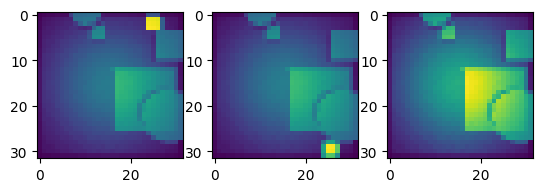

In [7]:
## visualize a problem
problem_idx_viz = randint(0,num_problems-1)
fig = plt.figure()

plt.subplot(1, 3, 1)
plt.imshow(x_init_problem[problem_idx_viz].reshape((img_res,img_res)))

plt.subplot(1, 3, 2)
plt.imshow(x_goal_problem[problem_idx_viz].reshape((img_res,img_res)))

plt.subplot(1, 3, 3)
plt.imshow(xempty_problem[problem_idx_viz].reshape((img_res,img_res)))

plt.show()

i =  0 , t =  0.07806754112243652
i =  100 , t =  0.22782444953918457
i =  200 , t =  0.38170886039733887
i =  300 , t =  0.5682528018951416
i =  400 , t =  0.7433040142059326
i =  500 , t =  0.9300441741943359
i =  600 , t =  1.1266894340515137
i =  700 , t =  1.348111629486084
i =  800 , t =  1.554002285003662
i =  900 , t =  1.7963500022888184


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

failure :(


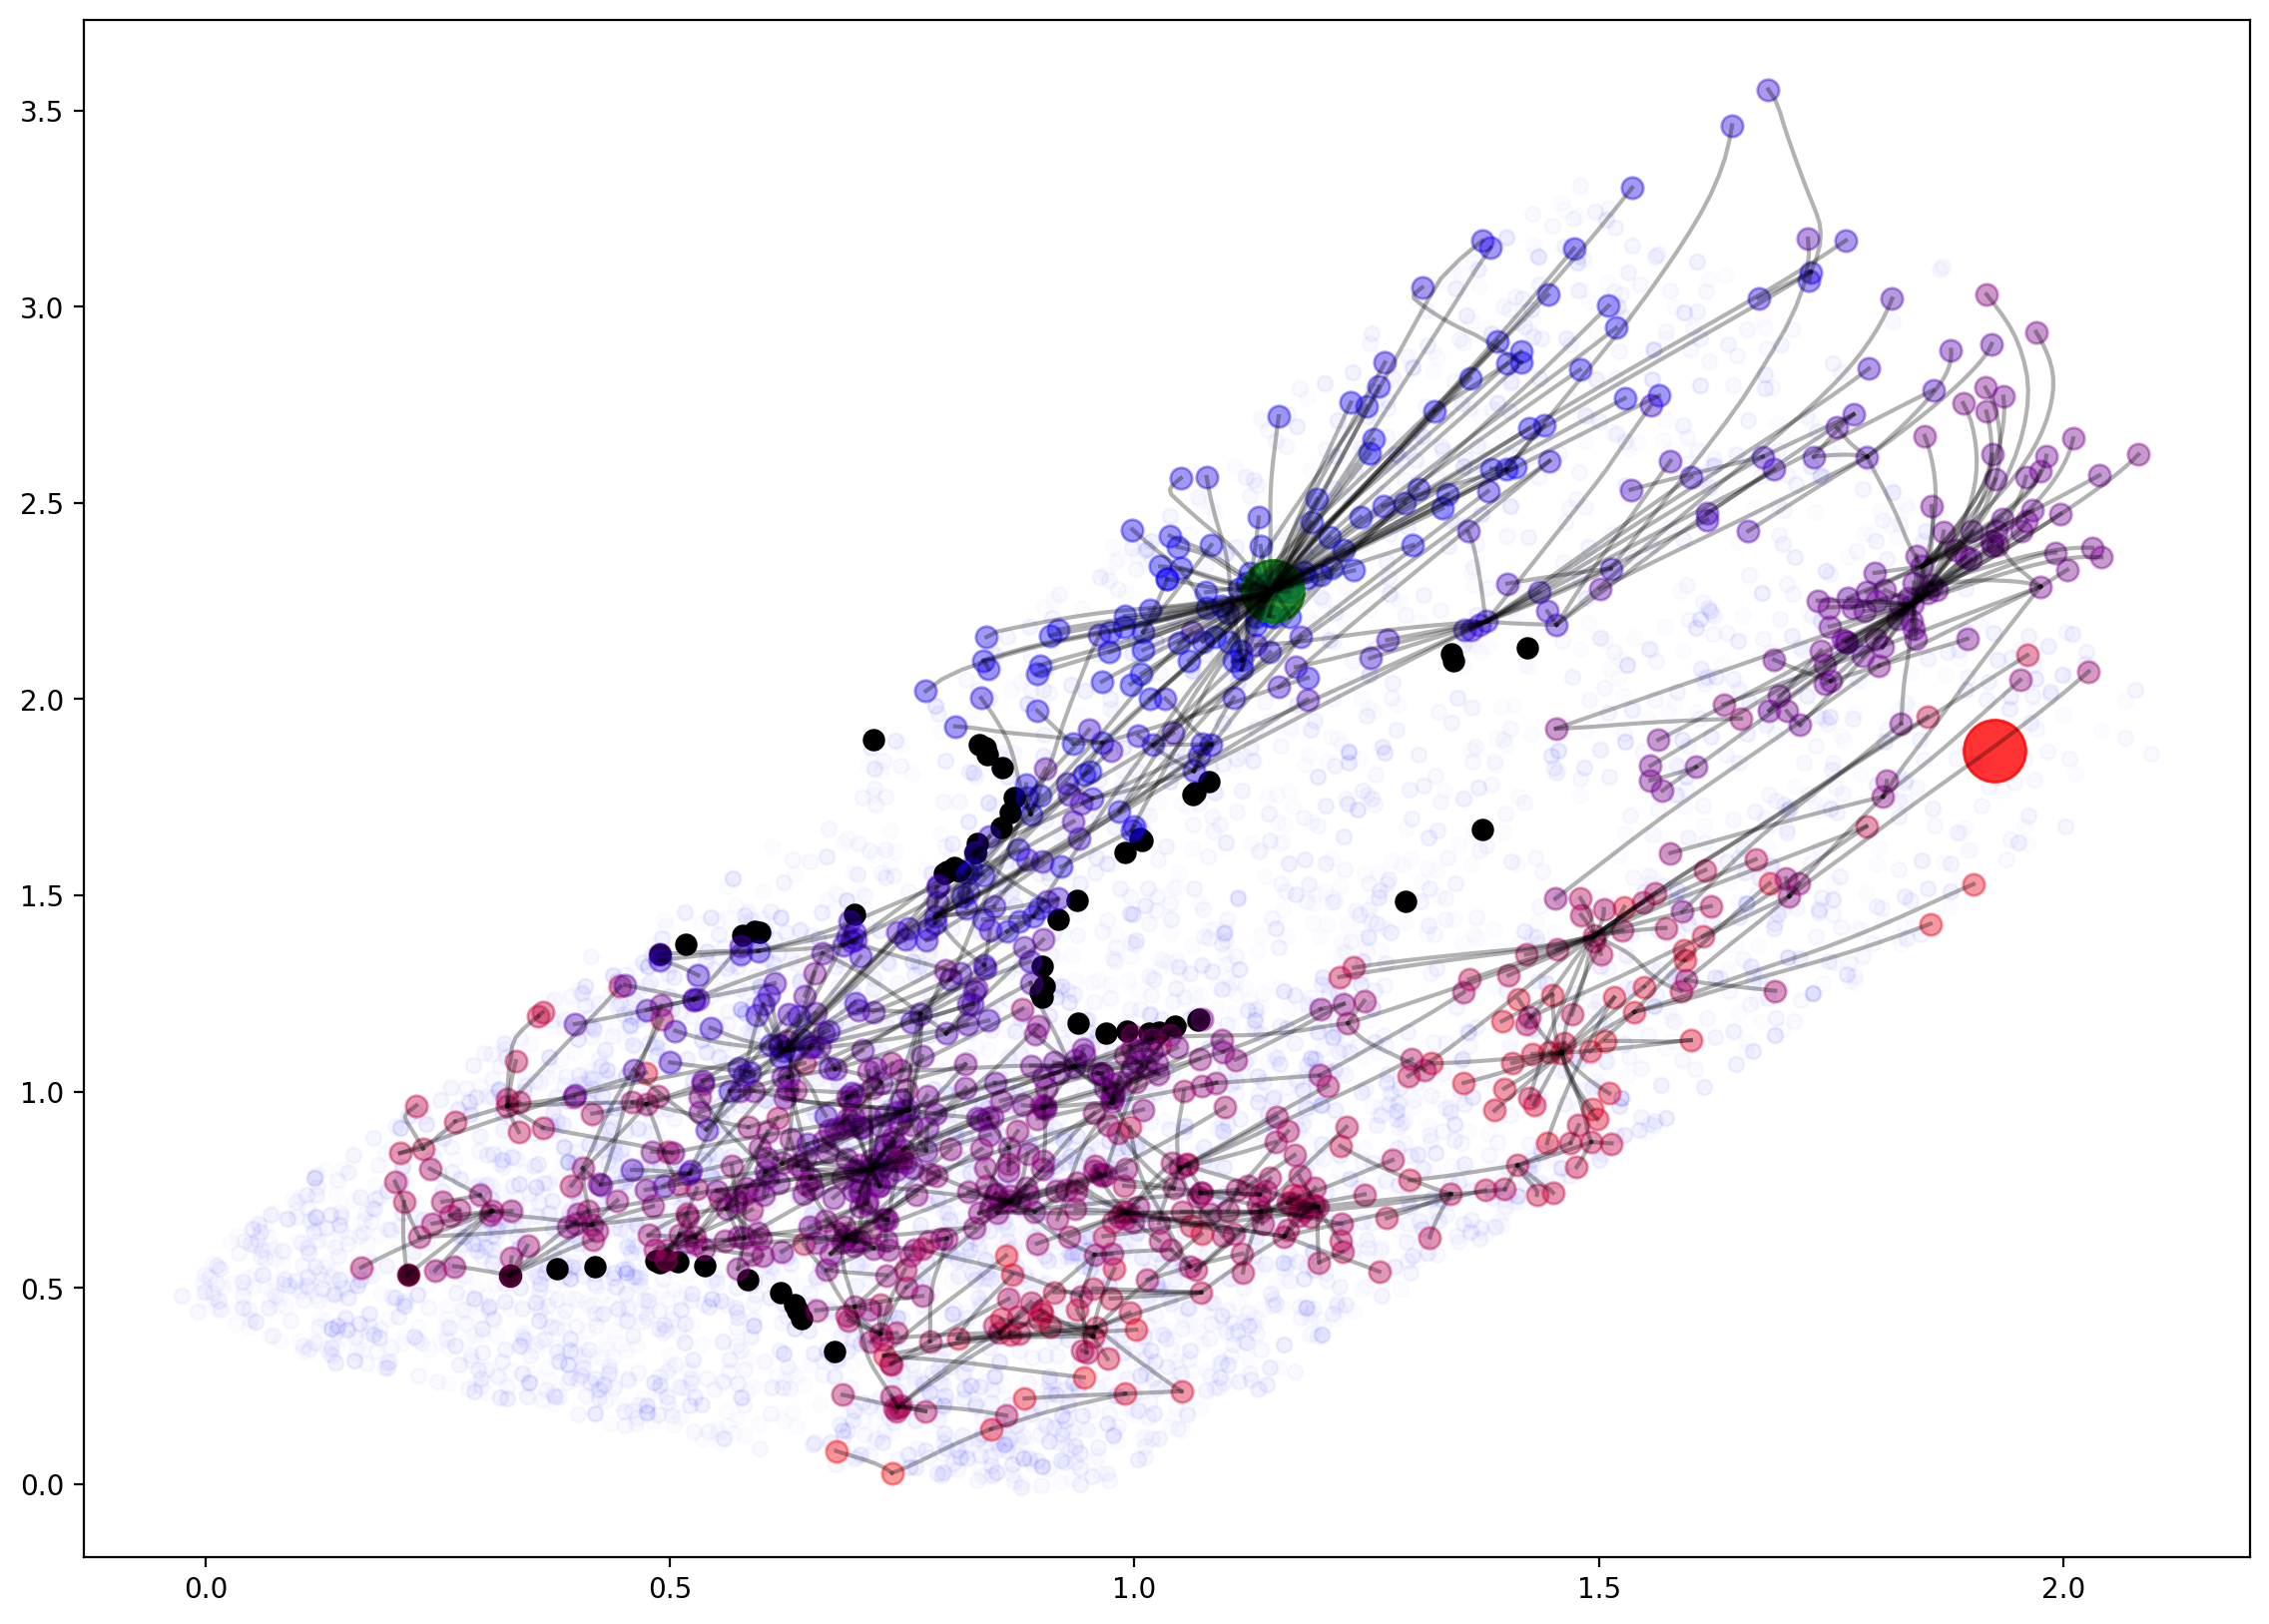

In [8]:
######## L2RRT ########

plotOn = True
num = 1000
success = False
count_success = 0
max_success = 100
T = 20
connection_radius = 0.15
stepsize = 0.1
radius_goal = 0.1
goal_bias = 0.1
cc_cutoff = 0.9 # only accept edges X likely to be collision free

# initialize empty tree
parents_rrt = np.zeros(num, dtype=int)-1 # index of parent node to each node
zs_rrt = np.zeros((num, z_dim)) # positions in latent space of elements of the tree
costs_rrt = np.zeros(num) # cost of each sample
trajs_rrt = np.zeros((num, T+1, z_dim))
T_rrt = np.zeros(num, dtype=int)
us_rrt = np.zeros((num, u_dim))

if plotOn:
    fig1 = plt.figure(figsize=(14,10), dpi=200)
plotOn and plt.scatter(samples_rrt[:,0], samples_rrt[:,1], color="blue", s=30, alpha=0.01) # current

start_time = time.time()

# choose problem
idx_problem = randint(0,num_problems-1) 
x_init_rrt = x_init_problem[idx_problem,:]
x_goal_rrt = x_goal_problem[idx_problem,:]
xempty_rrt = xempty_problem[idx_problem,:]

# encode problem
zs_local = sess.run([z], 
           feed_dict={x: [x_init_rrt], xp: [x_goal_rrt], xempty: [xempty_rrt], 
                      u: np.zeros((1,u_dim))})[0]

zs_rrt[0,:] = zs_local[0,:]
z_goal = zs_local[1,:]
G_inv_goal = sess.run([G_inv], feed_dict={zc: [z_goal], u: np.zeros((1,u_dim))})[0]
itrs_rrt = 1
dense_CC_conv_out = sess.run([dense_CC_conv], feed_dict={x_CC: [xempty_rrt]})

# explore
for i in range(0,num-1):
    idx_expand = randint(0,num-1)
    sample_expand = samples_rrt[idx_expand,:]
    G_inv_expand = G_inv_rrt[idx_expand,:,:]
    
    if random() < goal_bias:
        sample_expand = z_goal
        G_inv_expand = G_inv_goal
  
    # best near neighbor within ball radius
    neighbors_heap = []
    for nn in range(0,itrs_rrt):
        dz = zs_rrt[nn,:] - sample_expand
        if dz.dot(G_inv_expand).dot(dz) < connection_radius:
            heappush(neighbors_heap,(costs_rrt[nn], nn)) # push 0 in
    
    if len(neighbors_heap) > 0:
        neighbor_entry = heappop(neighbors_heap)
        idx_neighbor = neighbor_entry[1]
    else: # take the nearest node    
        idx_neighbor = -1
        neighbor_cost = np.infty
        for nn in range(0,itrs_rrt):
            dz = zs_rrt[nn,:] - sample_expand
            if dz.dot(G_inv_expand).dot(dz) < neighbor_cost:
                neighbor_cost = dz.dot(G_inv_expand).dot(dz)
                idx_neighbor = nn
    
    z_expand = zs_rrt[idx_neighbor];
    z_expand_idx = idx_neighbor;
    
    # sample controls and forward propagate
    # The may be accelerated by sampling many points in parallel. By then batching the tensorflow call, this shouldn't incur much slowdown
    isFree_expand = True
    uc_expand = np.random.uniform(-stepsize/5,stepsize/5,size=(z_dim))
    T_expand = randint(1,T)
    traj_exp = np.zeros((T+1, z_dim))
    traj_exp[0,:] = z_expand
    
    for t in range(0,T_expand):
        zp_expand = sess.run([zp_predict], feed_dict={zc: [z_expand], uc: [uc_expand]})[0]
        z_expand = zp_expand[0]
        traj_exp[t+1,:] = z_expand
    
    # check collision
    y_CC_expand = sess.run([y_CC], feed_dict={z1_CC: traj_exp[0:T_expand], z2_CC: traj_exp[1:T_expand+1], 
                                              dense_CC_conv: np.tile(dense_CC_conv_out[0],(T_expand,1))})[0]
    
    value_CC_expand = 1 / (1 + np.exp(-y_CC_expand))
    isNotFree_expand_t = value_CC_expand < cc_cutoff
    if np.any(isNotFree_expand_t):
        isFree_expand = False
        plotOn and plt.scatter(traj_exp[np.where(isNotFree_expand_t)[0][0],0], 
                               traj_exp[np.where(isNotFree_expand_t)[0][0],1], color="black", s=50, alpha=1)

    # can also add the expanded edge up to the state of collision
    if not isFree_expand: # the connection wasn't successful
        continue;
        
    # add to tree
    costs_rrt[itrs_rrt] = costs_rrt[z_expand_idx] + np.linalg.norm(uc_expand)*T_expand # T_expand + 
    parents_rrt[itrs_rrt] = z_expand_idx
    zs_rrt[itrs_rrt] = zp_expand
    trajs_rrt[itrs_rrt] = traj_exp
    us_rrt[itrs_rrt] = uc_expand
    T_rrt[itrs_rrt] = T_expand
    
    # or don't break and keep going and take the best over time
    if np.linalg.norm(zs_rrt[itrs_rrt,:] - z_goal) < radius_goal:
        if count_success == 0:
            print('success')
            success = True
        count_success += 1
        if count_success > max_success:
            break;
    
    itrs_rrt += 1
    if np.mod(i,100) == 0:
        print('i = ', i,', t = ', time.time()-start_time)

# plot nodes and costs
max_cost = np.max(costs_rrt)
for i in range(1,itrs_rrt):
    color = costs_rrt[i]/max_cost
    plotOn and plt.scatter(zs_rrt[i,0], zs_rrt[i,1], c=[color, 0, 1-color], s=60, alpha=0.4)
    plotOn and plt.plot(trajs_rrt[i,0:T_rrt[i]+1,0], trajs_rrt[i,0:T_rrt[i]+1,1], c='black', alpha=0.3)
    
# plot solution trajectory
if success:
    # shorest time path
    best_T = np.infty
    idx_soln_T = 0
    for i in range(0,itrs_rrt):
        if np.linalg.norm(zs_rrt[i,:] - z_goal) < radius_goal:
            tmp_T = 0
            tmp_idx = i
            while not parents_rrt[tmp_idx] == -1:
                tmp_T += T_rrt[tmp_idx]
                tmp_idx = parents_rrt[tmp_idx]
            if tmp_T < best_T:
                best_T = tmp_T
                idx_soln_T = i
            
    # best cost path
    best_T = np.infty
    idx_soln_T = 0
    for i in range(0,itrs_rrt):
        if np.linalg.norm(zs_rrt[i,:] - z_goal) < radius_goal:
            if costs_rrt[i] < best_T:
                best_T = costs_rrt[i]
                idx_soln_T = i
        
    idx = idx_soln_T
    while not parents_rrt[idx] == -1:
        plotOn and plt.plot(trajs_rrt[idx,0:T_rrt[idx]+1,0], trajs_rrt[idx,0:T_rrt[idx]+1,1], c='green', alpha=0.8, linewidth=5)
        idx = parents_rrt[idx]
else: 
    print("failure :(")

plotOn and plt.scatter(zs_rrt[0,0], zs_rrt[0,1], color="green", s=500, alpha=0.8) # plot init
plotOn and plt.scatter(z_goal[0], z_goal[1], color="red", s=500, alpha=0.8) # plot init
plotOn and plt.show()

goal


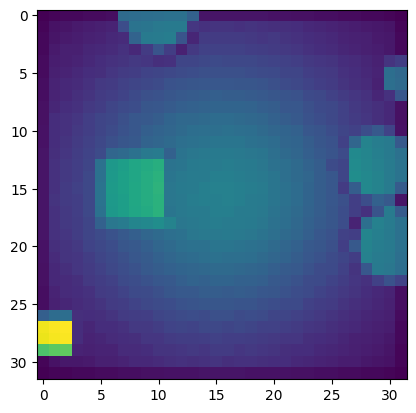

failure :(
init


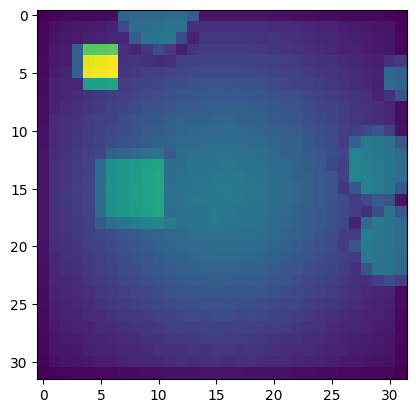

In [9]:
#### Plot the final solution trajectory, decoded into the full state space
print('goal')
plt.imshow(x_goal_rrt.reshape((img_res,img_res)))
plt.show()

if success:
    best_T = np.infty
    idx_soln_T = 0
    for i in range(0,itrs_rrt):
        if np.linalg.norm(zs_rrt[i,:] - z_goal) < radius_goal:
            tmp_T = 0
            tmp_idx = i
            while not parents_rrt[tmp_idx] == -1:
                tmp_T += T_rrt[tmp_idx]
                tmp_idx = parents_rrt[tmp_idx]
            if tmp_T < best_T:
                best_T = tmp_T
                idx_soln_T = i

    # best cost path
    best_T = np.infty
    idx_soln_T = 0
    for i in range(0,itrs_rrt):
        if np.linalg.norm(zs_rrt[i,:] - z_goal) < radius_goal:
            if costs_rrt[i] < best_T:
                best_T = costs_rrt[i]
                idx_soln_T = i
    print('best cost = ', best_T)

    idx = idx_soln_T
    while not parents_rrt[idx] == -1:
        ys_rrt = sess.run([y], feed_dict={xempty_full: [xempty_rrt], inputs_P: [zs_rrt[idx]]})
        plt.imshow(ys_rrt[0].reshape((img_res,img_res)))
        plt.show()
        idx = parents_rrt[idx]
else: 
    print("failure :(")

print('init')
plt.imshow(x_init_rrt.reshape((img_res,img_res)))
plt.show()